In [1]:
# using Plots
using LinearAlgebra
using SparseArrays
using PyPlot
using Revise

include("../smear_fem/src/fem.jl")
include("../smear_fem/src/PostProcess.jl")

In [2]:
fem.greet()

Hello, I am the FEM module


In [3]:
PostProcess.greet()

Hello, I am the PostProcess module


In [4]:
# test case 
x0 = 0
x1 = 1
y0 = 0
y1 = 1
ne = 10
h = (x1 - x0) / ne;

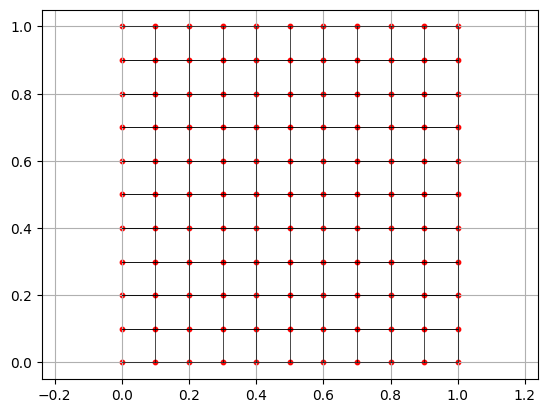

In [5]:
# set up mesh grid
function meshgrid(x0,x1,y0,y1,ne)
    x = collect(range(x0, x1, length=ne+1))
    y = collect(range(y0, y1, length=ne+1))
    
    NodeList = zeros(2,(ne+1)*(ne+1))

    k = 1
    for i in 1:ne+1
        for j in 1:ne+1
            NodeList[1,k] = x[j]
            NodeList[2,k] = y[i]
            k = k + 1
        end
    end

    IEN = zeros(Int64,ne*ne,4)
    
    l = 1
    for i in 1:ne
        for j in 1:ne
            IEN[l,1] = (i-1)*(ne+1) + j
            IEN[l,2] = (i-1)*(ne+1) + j + 1
            IEN[l,3] = i*(ne+1) + j + 1
            IEN[l,4] = i*(ne+1) + j
            l = l + 1
        end
    end

    return NodeList, IEN
end

NodeList, IEN = meshgrid(x0,x1,y0,y1,ne)

fig1 = plt.figure()
ax = fig1.add_subplot(111)

for i in 1:size(IEN,1)
    x = NodeList[1,IEN[i,:]]
    y = NodeList[2,IEN[i,:]]
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.scatter(NodeList[1,:],NodeList[2,:],s=10,c="r")
ax.axis("equal")
ax.grid("on")

gcf()


In [6]:
function setboundaryCond(NodeList, ne)
    # set dirichlet boundary conditions
    q_d = zeros((ne+1)*(ne+1),1)
    q_n = zeros((ne+1)*(ne+1),1)
    Dbound1 = 0
    Dbound2 = 1
    Nbound = 0

    # definition of the constraint matrix
    C = Matrix{Int}(I,(ne+1)*(ne+1),(ne+1)*(ne+1))

    for n in 1:length(q_d)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[2] == Dbound1 # bottom boundary
            q_d[n] = 0
        elseif coord[2] == Dbound2 # top boundary
            q_d[n] = 1
        end
    end

    for n in 1:length(q_n)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[1] == Nbound # left boundary
            q_n[n] = 0
        end 
    end

    C = C[:,(ne+2):((ne+1)*(ne+1)-(ne+1))]
    
    return q_d, q_n, C
end

q_d, q_n, C = setboundaryCond(NodeList, ne);

In [7]:
x, y = meshgrid(x0,x1,y0,y1,ne)

# (I,J,V) vectors for COO sparse matrix
E = zeros(Int64, 16*ne*ne)
J = zeros(Int64, 16*ne*ne)
V = zeros(Float64, 16*ne*ne)

v = 0

# element loop
b = zeros((ne+1)*(ne+1),1)

for e in 1:ne*ne
    # define bounding coordinates of the element should not be condirered when isoparametric coordinates are used
    x_1 = NodeList[1,IEN[e,1]]
    y_1 = NodeList[2,IEN[e,1]]

    x_2 = NodeList[1,IEN[e,2]]
    y_2 = NodeList[2,IEN[e,2]]

    x_3 = NodeList[1,IEN[e,3]]
    y_3 = NodeList[2,IEN[e,3]]

    x_4 = NodeList[1,IEN[e,4]]
    y_4 = NodeList[2,IEN[e,4]]

    # gaussian quadrature points
    xi, w_xi = fem.gaussianQuadrature(x_1,x_2)
    eta, w_eta = fem.gaussianQuadrature(y_1,y_3)

    wpoints = [w_xi[1]*w_eta[1], w_xi[2]*w_eta[1], w_xi[2]*w_eta[2], w_xi[1]*w_eta[2]]
    
    x = [xi[1], xi[2], xi[2], xi[1]]
    y = [eta[1], eta[1], eta[2], eta[2]]

    # integration loop
    for gp in 1:4
        N, Delta_N = fem.basis_function_glob(x_1,x_2,y_1,y_3,x[gp],y[gp],h)

        # loop between basis functions of the element
        for i in 1:4
            for j in 1:4
                inz = 16*(e-1) + 4*(i-1) + j # index for COO sparse matrix
                E[inz] = IEN[e,i] # row index 
                J[inz] = IEN[e,j] # column index
                V[inz] += wpoints[gp]*dot(Delta_N[i,:],Delta_N[j,:]) # inner product of the gradient of the basis functions
            end
        end
    end
end
q_d, q_n, C = setboundaryCond(NodeList, ne)

# assemble the stiffness matrix
K = sparse(E,J,V)

# transpose the constraint matrix
C_t = transpose(C)

# extract the free part of the stiffness matrix
K_free = C_t*K*C

b = q_n - K*q_d

# solve the system
q_f = K_free\C_t*b

# assemble the solution 
q = q_d + C*q_f;

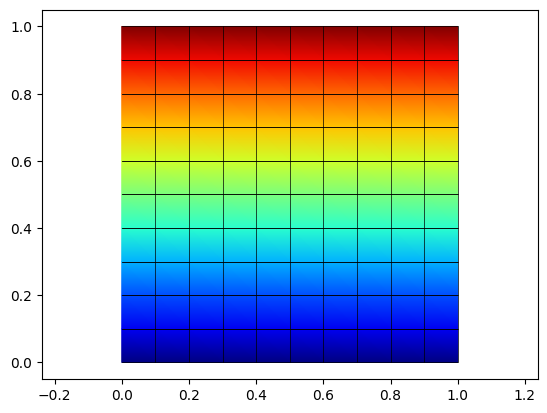

In [8]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
qList = PostProcess.noramlize(q, IEN)

for i in 1:size(IEN,1)
    x = NodeList[1,IEN[i,:]]
    y = NodeList[2,IEN[i,:]]
    c = qList[i,:]
    cmap = PostProcess.truncate_colormap(maximum(c), minimum(c))
    ax.tripcolor(x, y, c, cmap=cmap,shading="gouraud" )
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.axis("equal")
gcf()

Plotting basis functions


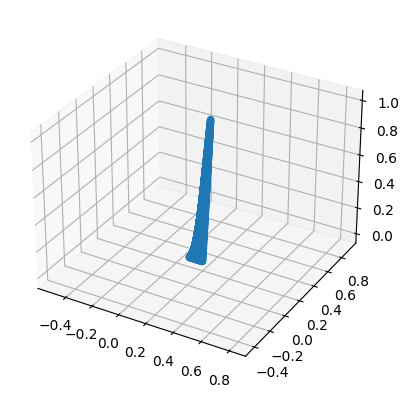

In [9]:
function plot_basis_functions(NodeList, IEN, ne)

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    println("Plotting basis functions")

    e = 22

    x_1 = NodeList[1,IEN[e,1]]
    y_1 = NodeList[2,IEN[e,1]]

    x_2 = NodeList[1,IEN[e,2]]
    y_3 = NodeList[2,IEN[e,3]]


    h = x_2 - x_1

    x = collect(range(x_1, x_2, length=100))
    y = collect(range(y_1, y_3, length=100))

    z1 = zeros(size(x,1)*size(y,1),1)
    z2 = zeros(size(x,1)*size(y,1),1)
    z3 = zeros(size(x,1)*size(y,1),1)
    z4 = zeros(size(x,1)*size(y,1),1)

    xpos = zeros(size(x,1)*size(y,1),1)
    ypos = zeros(size(x,1)*size(y,1),1)

    k = 1
    for i in 1:size(x,1)
        for j in 1:size(y,1)
            N, Delta_N = fem.basis_function_glob(x_1, x_2, y_1, y_3, x[i], y[j], h)

            xpos[k] = x[i]
            ypos[k] = y[j]

            z1[k] = N[1]
            z2[k] = N[2]
            z3[k] = N[3]
            z4[k] = N[4]
            k = k + 1
        end
    end

    ax.scatter(xpos, ypos, z1, "-r", label="N1")
    # ax.scatter(x, y, z2, "-g", label="N2")
    # ax.plot(x, y, z3, "-b", label="N3")
    # ax.plot(x, y, z4, "-y", label="N4")
    # ax.set_xlim(0, 1)
    # ax.set_ylim(0, 1)
    ax.axis("equal")
    ax.grid("on")
    
    gcf()
end

plot_basis_functions(NodeList, IEN, ne)